# Step 1: Undistort image


In [1]:
import pickle
import cv2
import matplotlib.pyplot as plt

In [2]:
# loading precomputed matrices for testing
# (prepared by the camera_calibration.ipynb script)
pickle_in = open("calibration_mat.pickle","rb")
calibration_mat_2 = pickle.load(pickle_in)

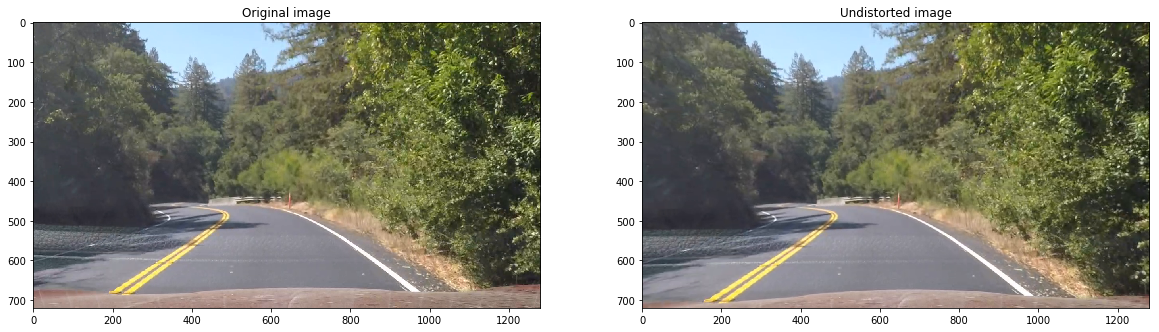

In [50]:
# Testing on an image that wasn't used for calibration
from moviepy.editor import VideoFileClip
from IPython.display import HTML


clip1 = VideoFileClip("./harder_challenge_video.mp4")
img = clip1.get_frame(1) 

ori_img = img

#fname = 'test_images/test2.jpg'
#img = cv2.imread(fname)

undistorted_img = cv2.undistort(img, calibration_mat_2['mtx'], calibration_mat_2['dist'], None, calibration_mat_2['mtx'])

#img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#undistorted_img = cv2.cvtColor(undistorted_img,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20));
plt.subplot(1,2,1)
plt.imshow(img);
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(undistorted_img);
plt.title('Undistorted image')
plt.savefig('examples/undistorted_test2.png', bbox_inches='tight')

 # Step 2:  Use color transforms, gradients or other methods to create a thresholded binary image

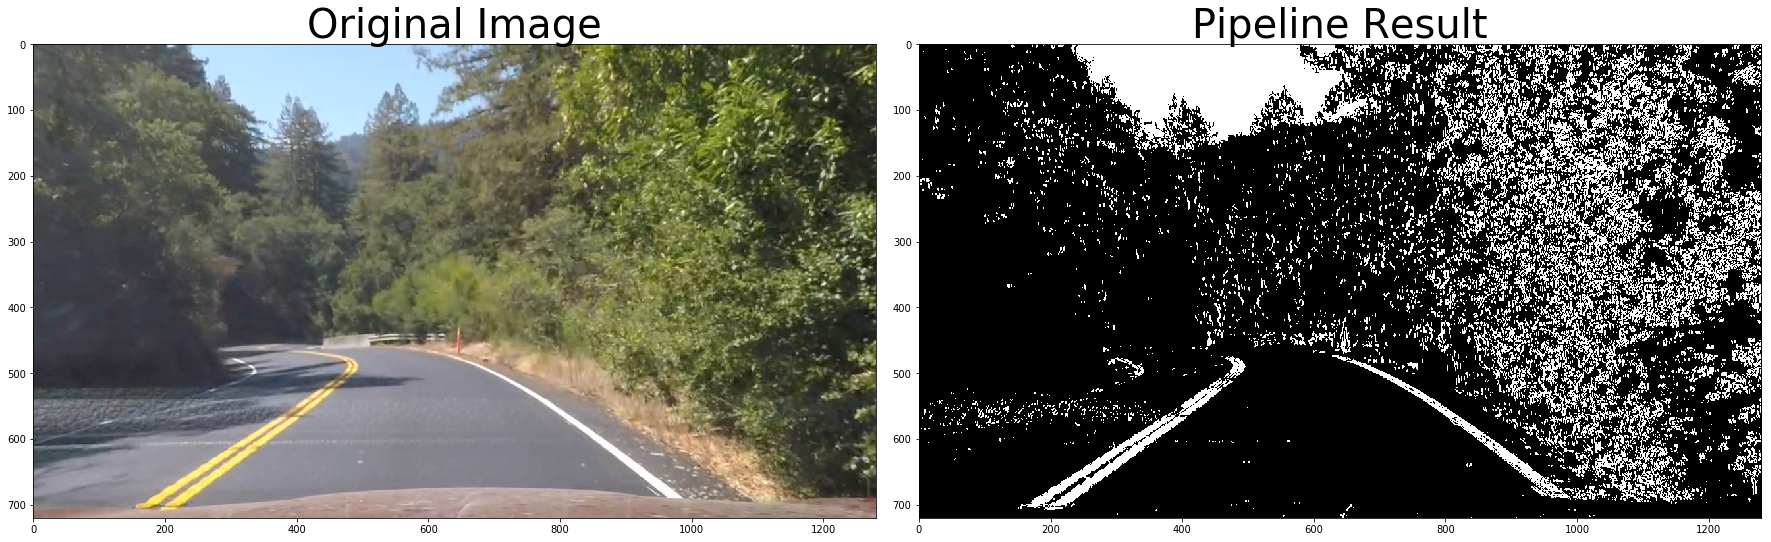

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = undistorted_img

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [34]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [35]:
imshape = result.shape
X = imshape[1]
Y = imshape[0]

#Define a region of interest
vertices = np.array([[(0,Y),(0.45*X, 0.55*Y), (0.55*X, 0.55*Y), (X,Y)]], dtype=np.int32)
selected_img = region_of_interest(result, vertices)

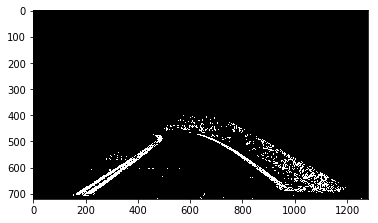

In [36]:
plt.imshow(selected_img, cmap='gray')

# Step 3: Perspective transform 

In [37]:
# Use an interactive windows to pick points
pickpoint = 0
if pickpoint:
    cv2.namedWindow('image') #, cv2.WINDOW_NORMAL)
    cv2.resize(undistorted_img, (0, 0), fx=2, fy=2)
    cv2.imshow('image',undistorted_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [38]:
# Four source cordinates
src = np.float32(
    [[254, 700],
     [595, 449],
     [688, 448],
     [1062, 693]
    ])
# Four desired cordinates
dst = np.float32(
    [[254, 700],
     [254, 0],
     [1062, 0],
     [1061, 693]
    ])

Minv = cv2.getPerspectiveTransform(dst, src)
M = cv2.getPerspectiveTransform(src, dst)
def warp(img, src, dst, M=None):
    img_size = (img.shape[1], img.shape[0])
    if M is None: M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def unwarp(img, src, dst, Minv=None):
    img_size = (img.shape[1], img.shape[0])
    if Minv is None: Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [39]:
warped = warp(undistorted_img, src, dst)

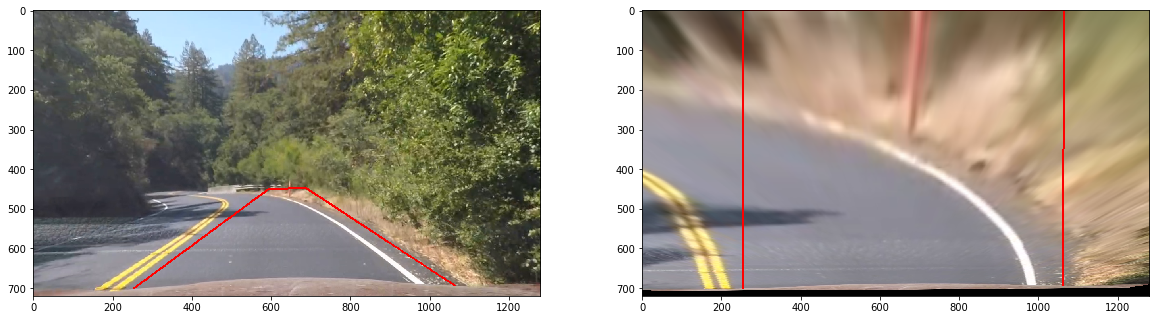

In [40]:
cv2.polylines(undistorted_img, [np.int32(src)], False, (255,0,0), 3)
cv2.polylines(warped, [np.int32(dst)], False, (255,0,0), 3)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(undistorted_img)
plt.subplot(1,2,2)
plt.imshow(warped)


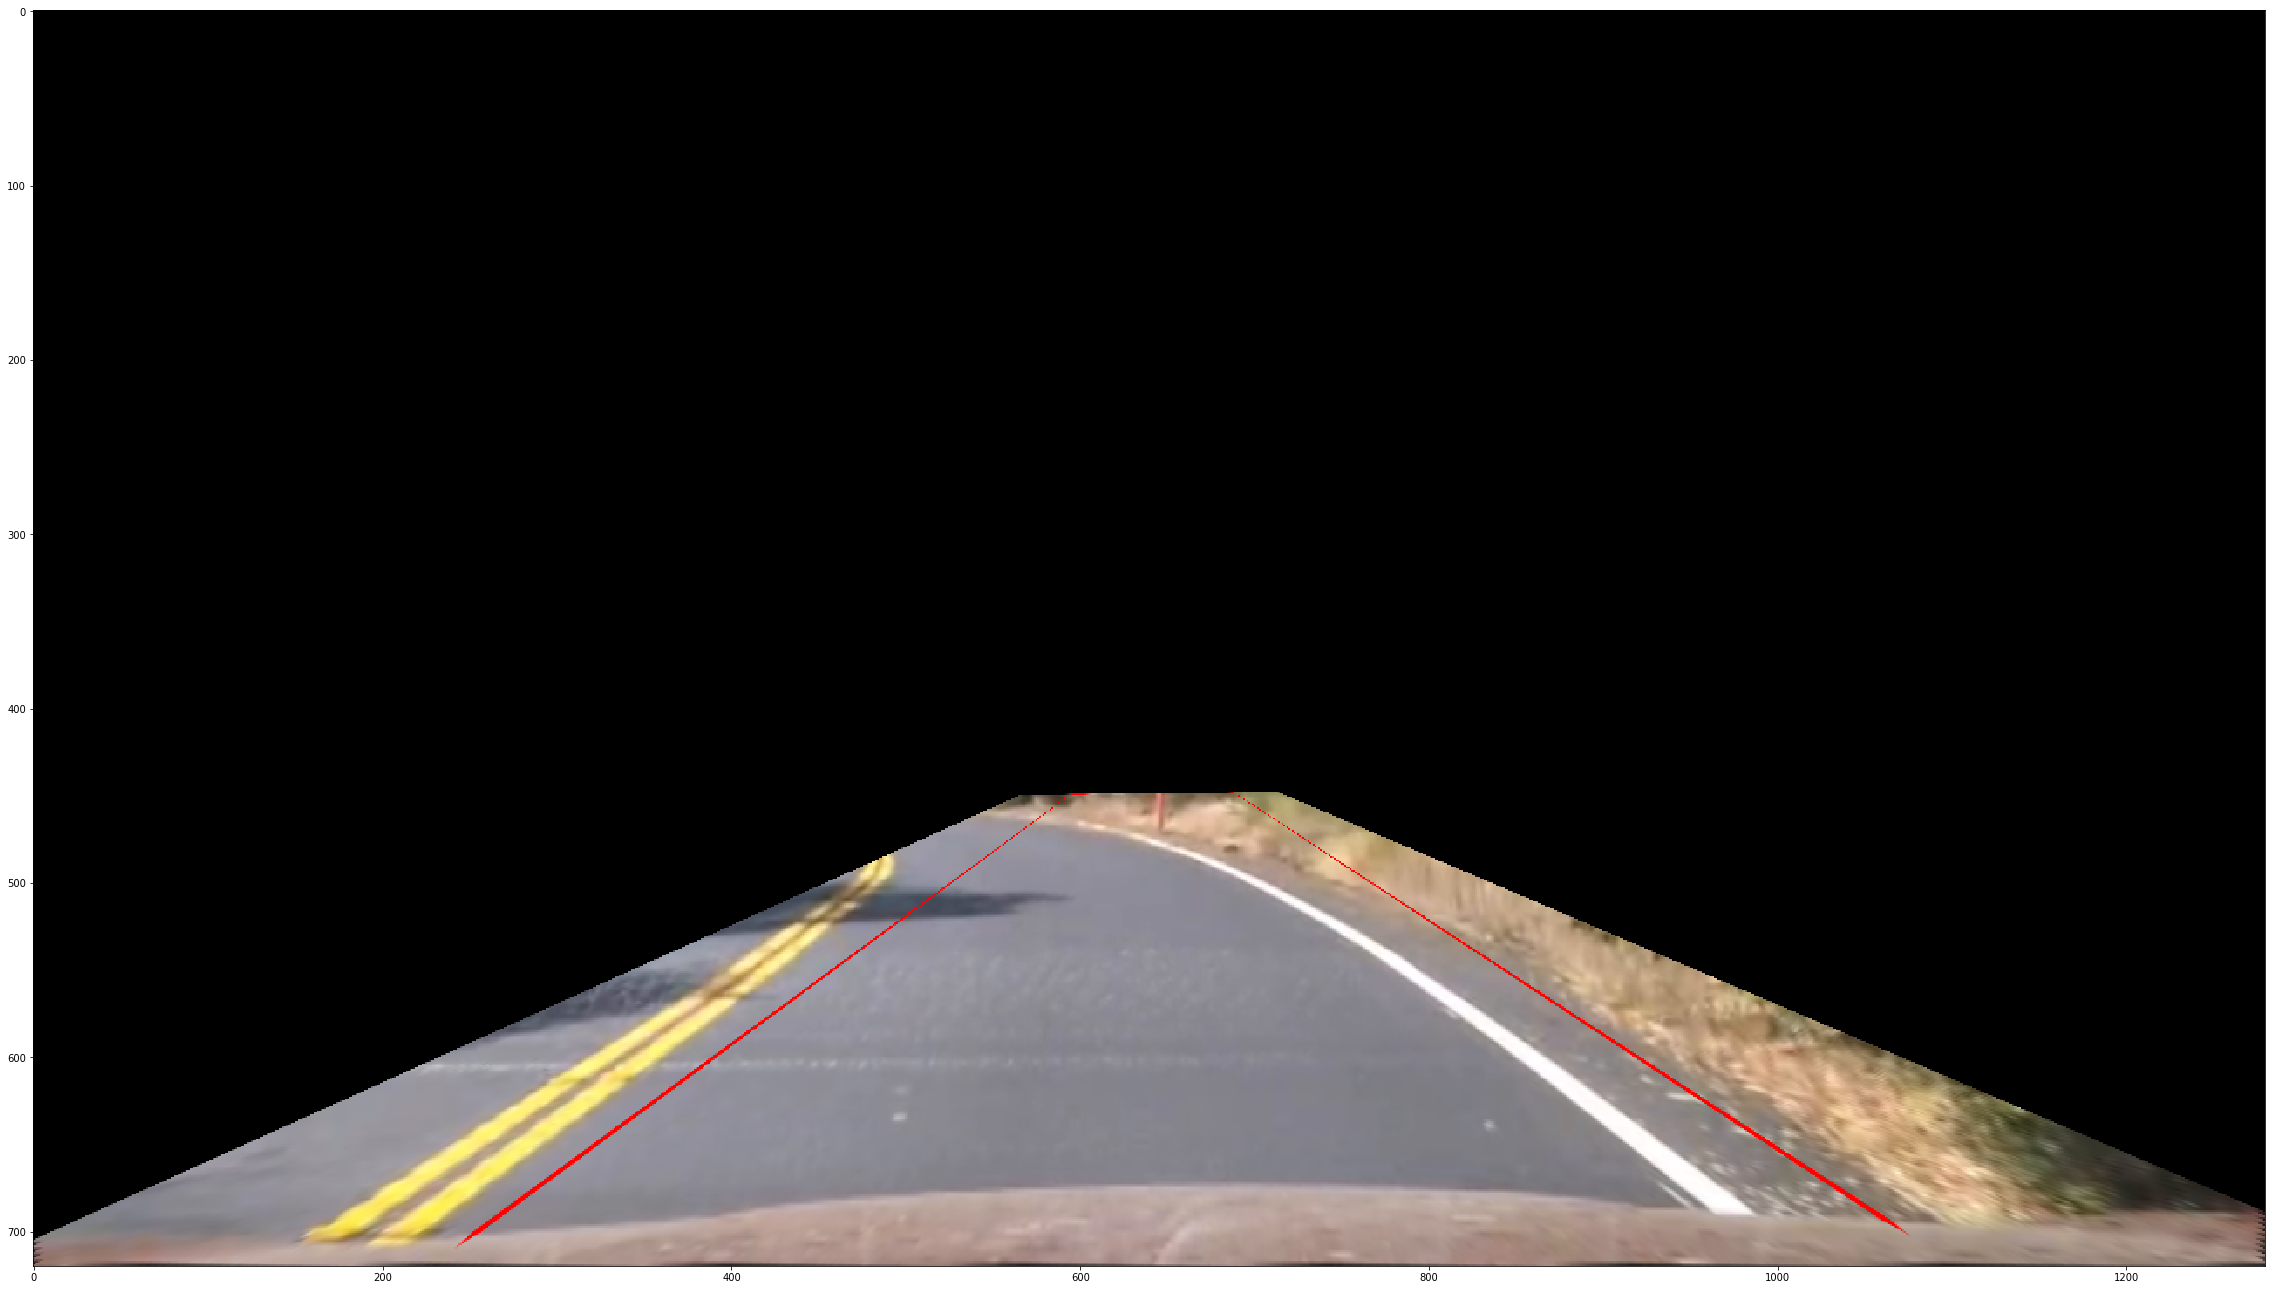

In [41]:
# Unwarped image
plt.figure(figsize=(40,40))
plt.imshow(unwarp(warped, src, dst))

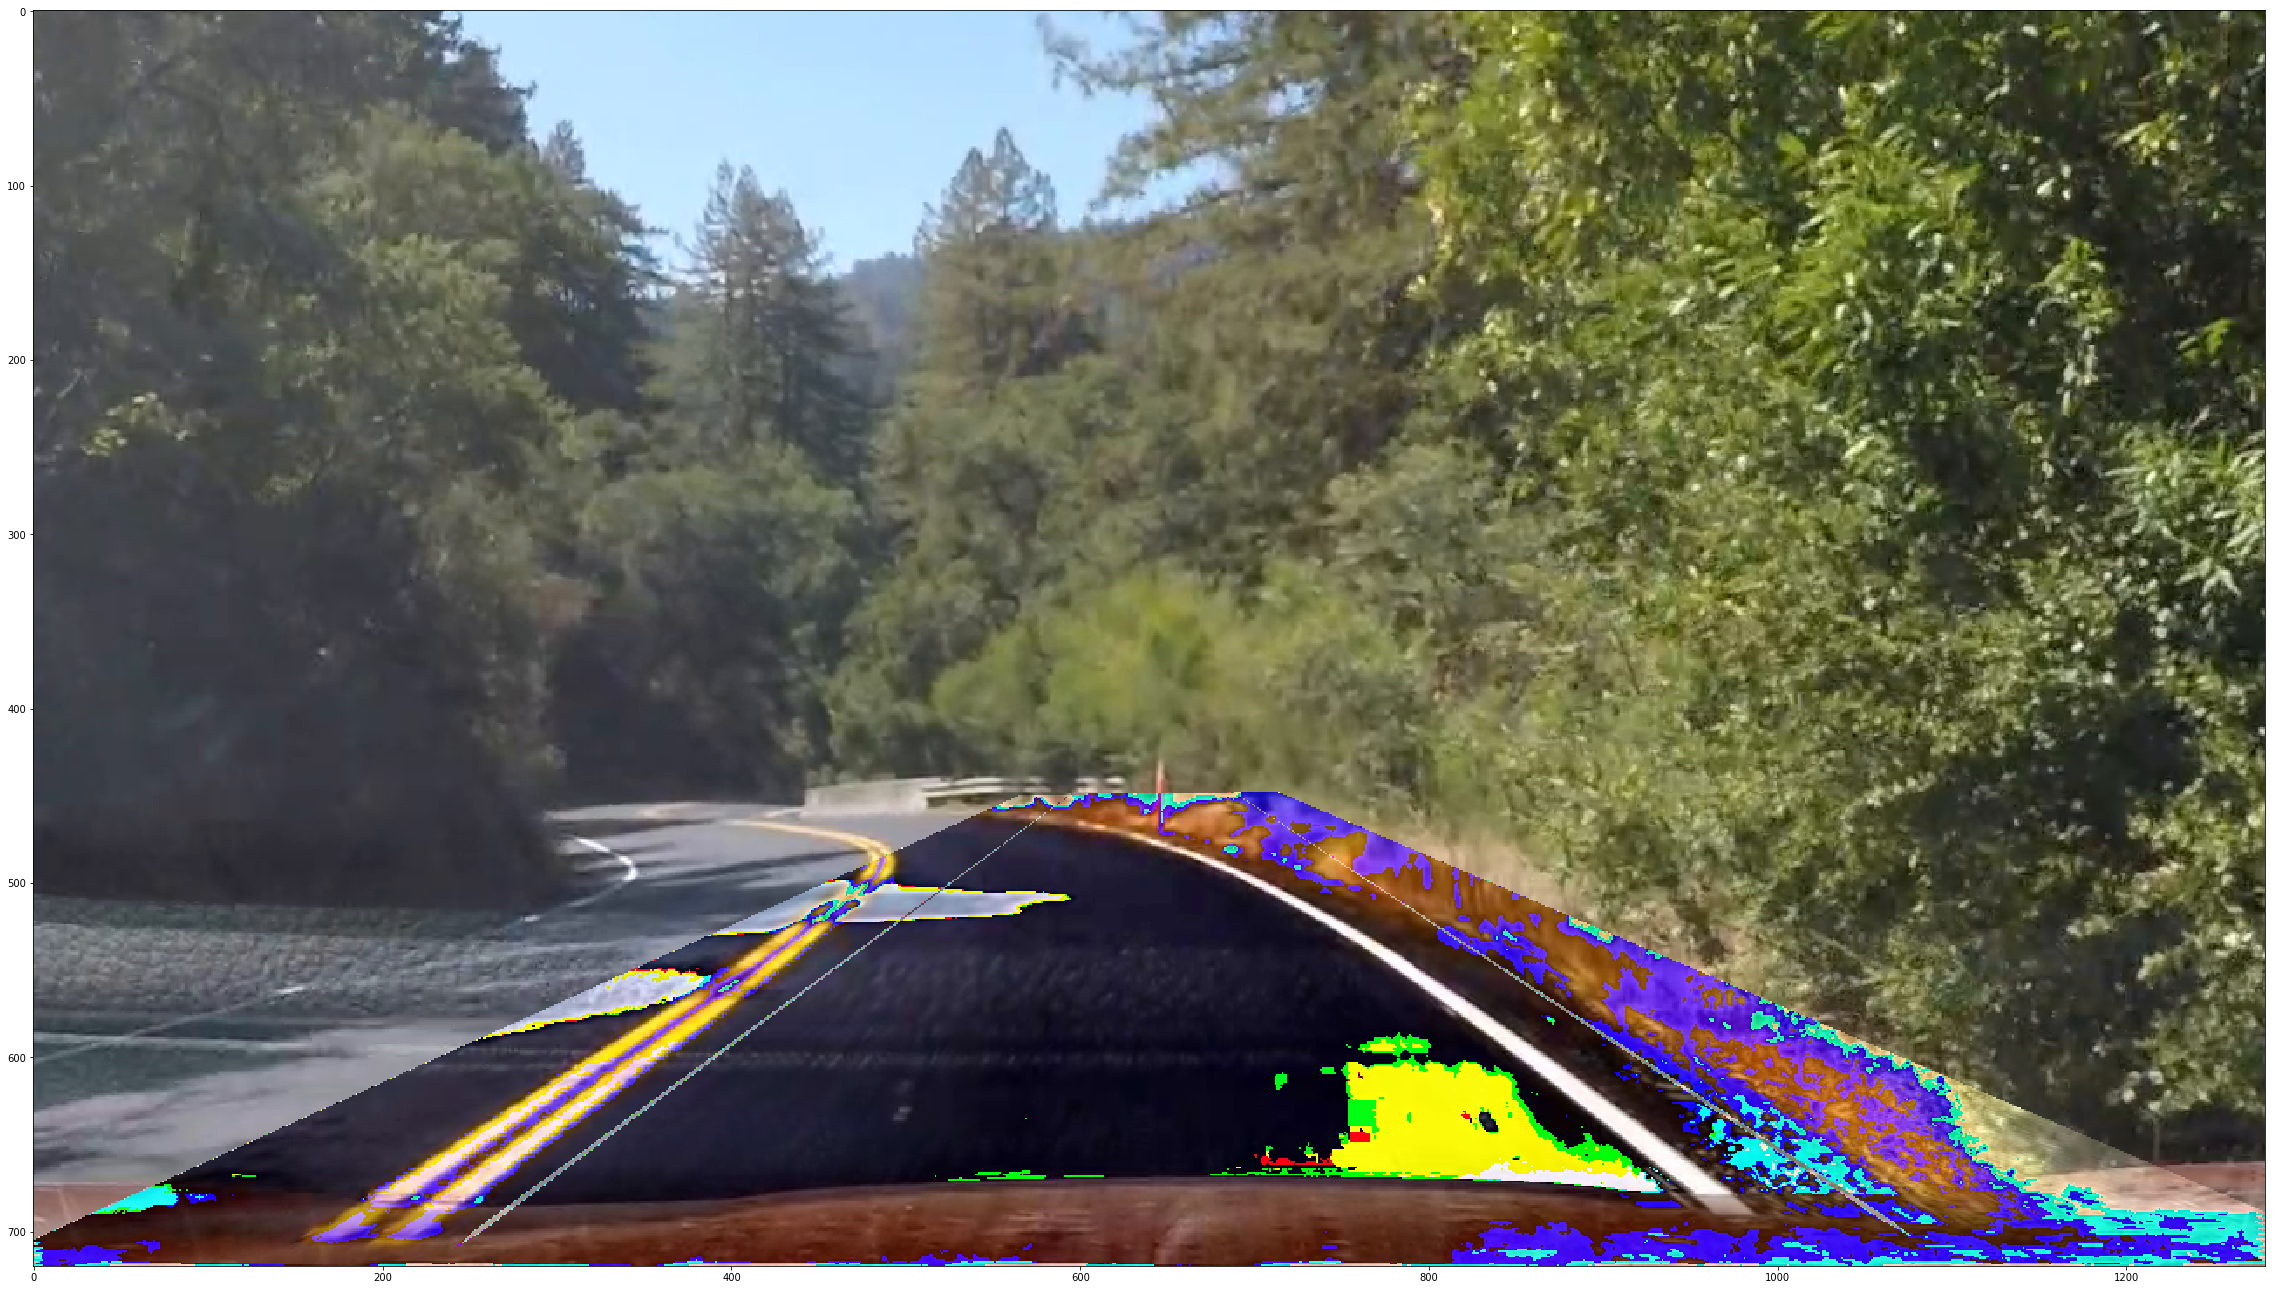

In [42]:
plt.figure(figsize=(40,40))
plt.imshow(img + unwarp(warped, src, dst))

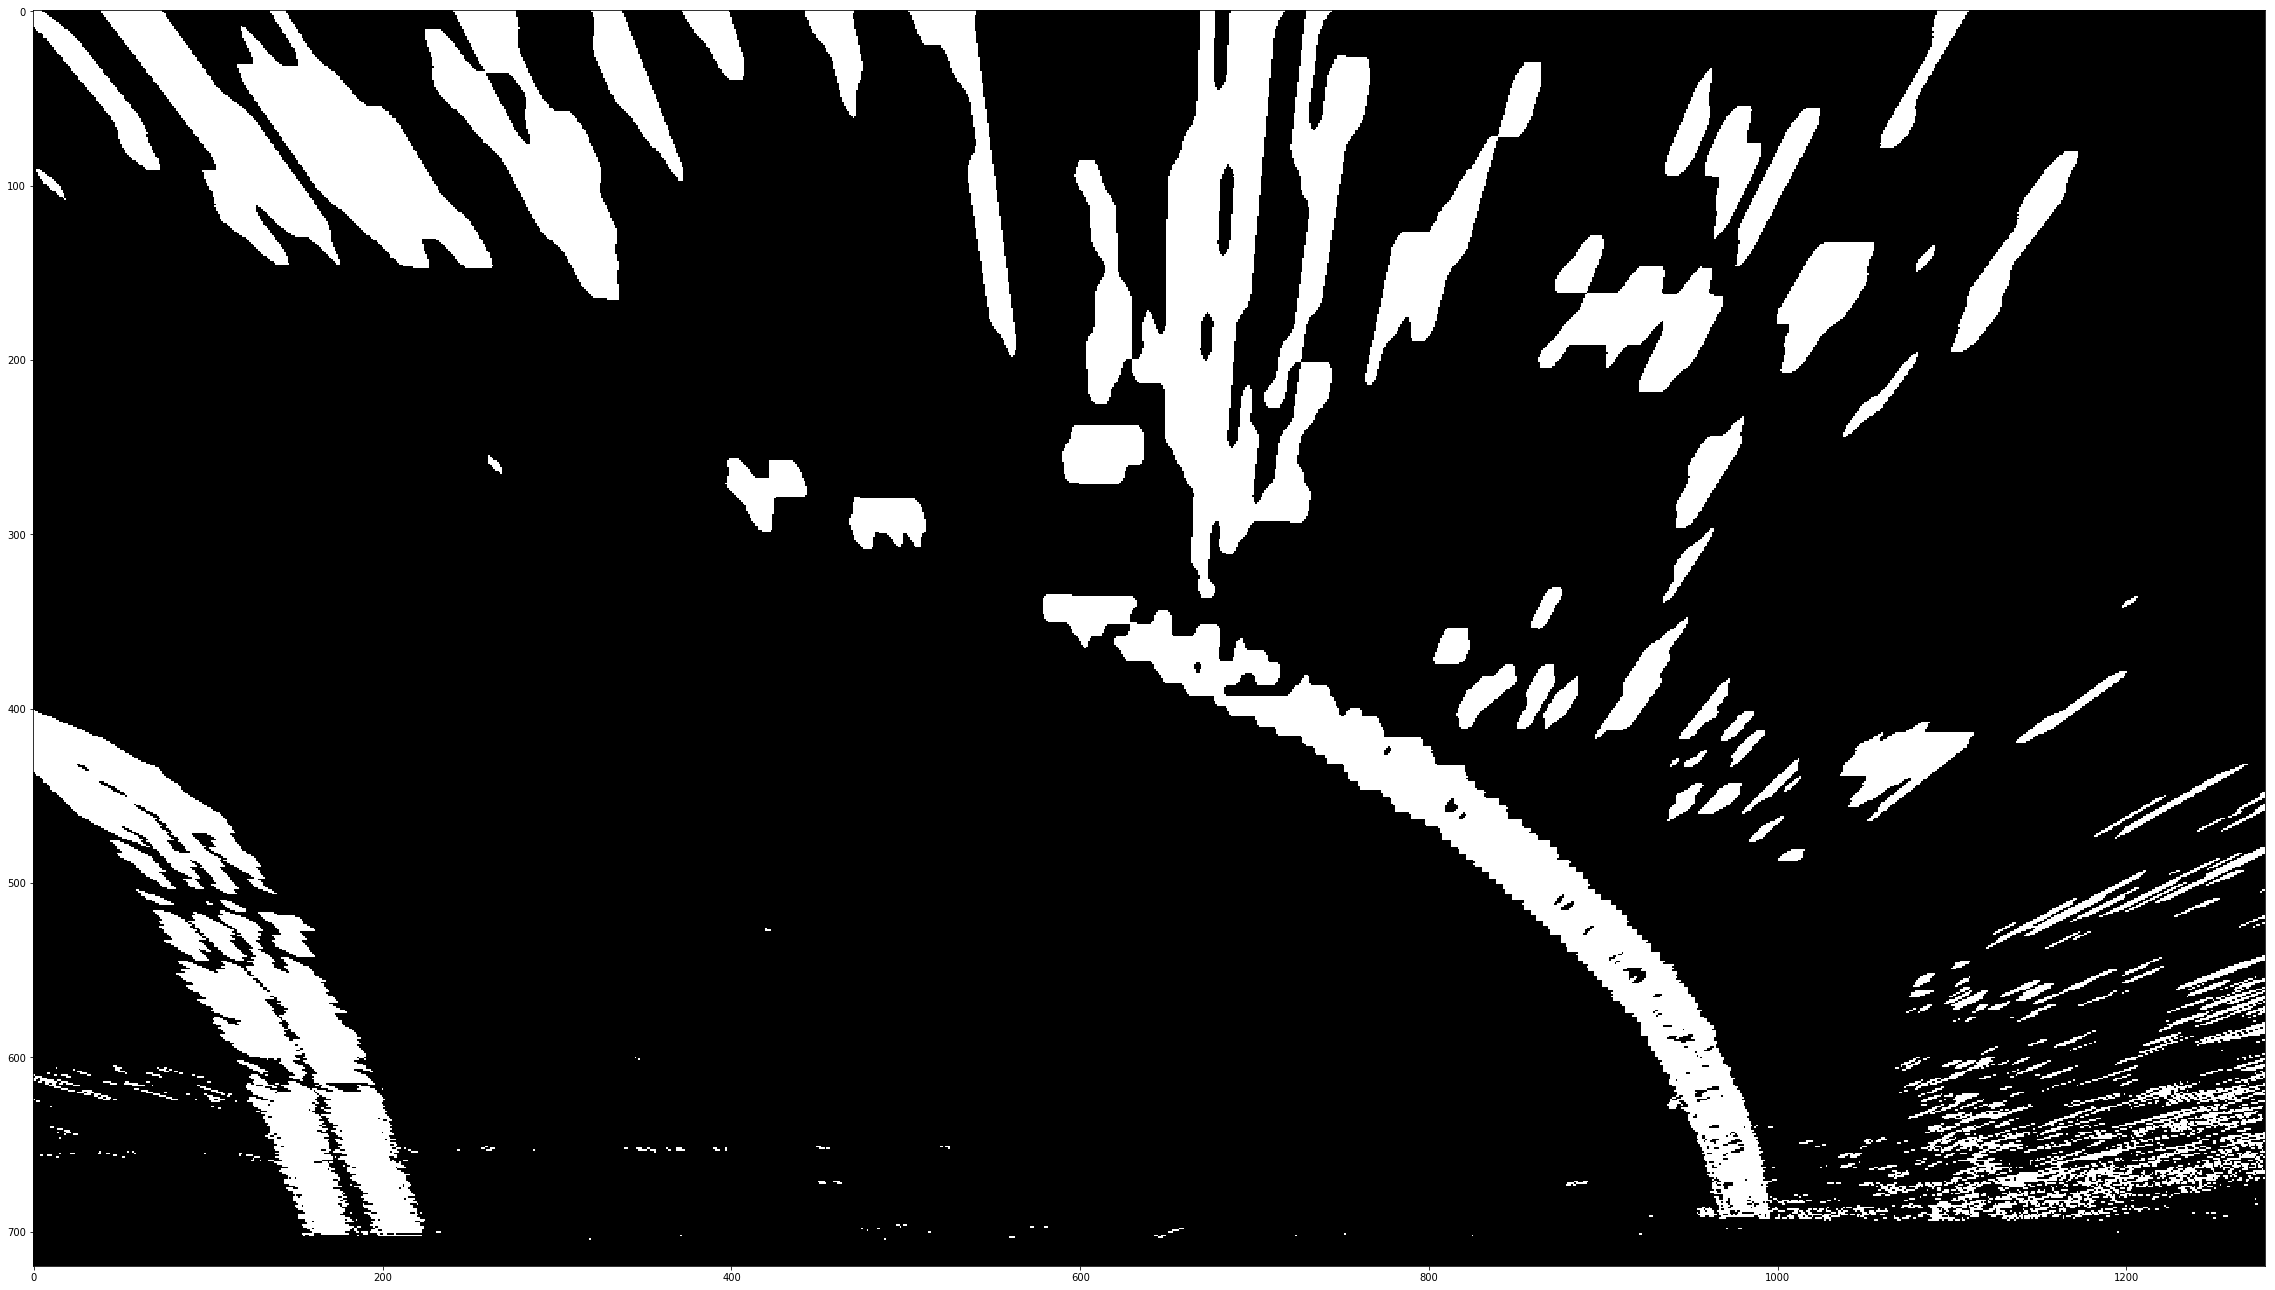

In [43]:
# Unwarped image
plt.figure(figsize=(40,40))
plt.imshow(warp(result, src, dst), cmap='gray')

# Step 4: Finding lane line


In [44]:
img = warp(result, src, dst)

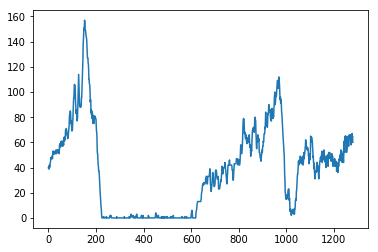

In [45]:
import numpy as np
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [46]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

binary_warped = img

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [47]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


1085.8567484389428 860.0282855926288
183.4118840758752 m 135.21742575389374 m


In [48]:
# Detect vehicle position: assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for.
mid_lane = (left_fitx[-1] + right_fitx[-1])/2
deviation_pixels = mid_lane - 1280/2
deviation_mettres = deviation_pixels * xm_per_pix

if deviation_mettres > 0 :
    position_str = 'Vehicle is %.2fm left of center'%deviation_mettres
else:
    position_str = 'Vehicle is %.2fm right of center'%deviation_mettres
print(position_str)


Vehicle is -0.12m right of center


# Step 6: Display lane area

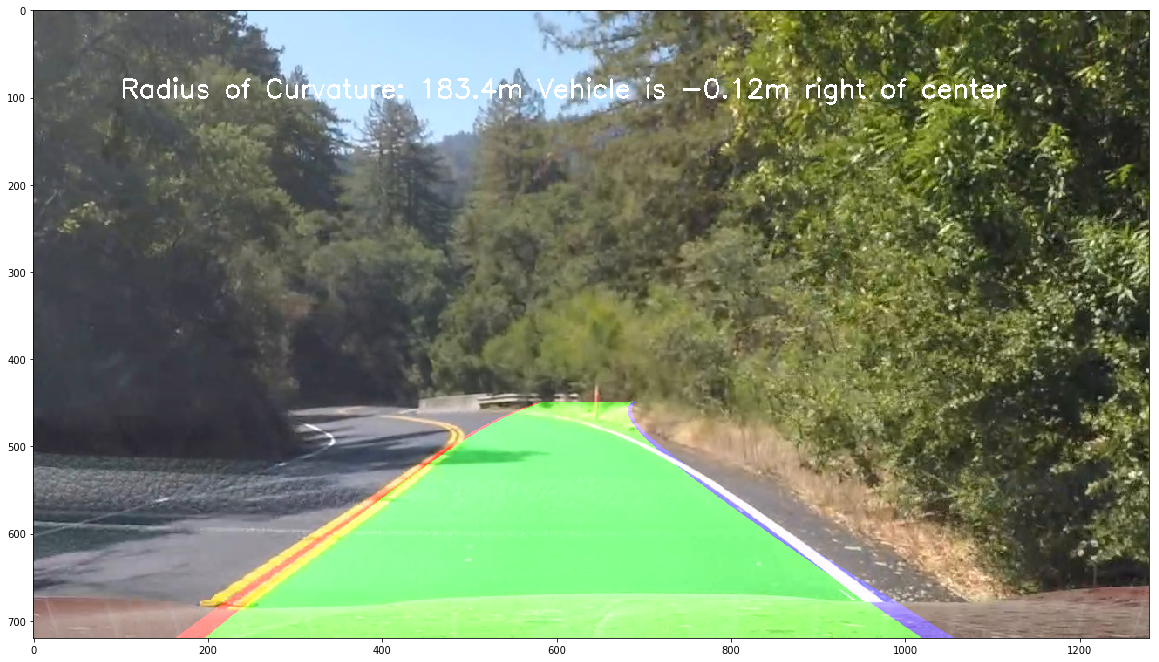

In [51]:
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a
    
# Create an image to draw the lines on
warp_zero = np.zeros((warped.shape[0], warped.shape[1])).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int32([pts]), (0,255, 0))

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

pts_left = np.int32(pts_left)
pts_right = np.int32(pts_right)
for i in range(len(pts_left[0])-1):
    cv2.line(color_warp,totuple(pts_left[0][i]),totuple(pts_left[0][i+1]),(255,0,0),25)
    cv2.line(color_warp,totuple(pts_right[0][i]),totuple(pts_right[0][i+1]),(0,0,255),25)
    

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image

#img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#undistorted_img = cv2.undistort(img, calibration_mat_2['mtx'], calibration_mat_2['dist'], None, calibration_mat_2['mtx'])

result = cv2.addWeighted(ori_img, 1, newwarp, 0.5, 0)

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (100,100)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

cv2.putText(result,'Radius of Curvature: %.1fm %s'%(max(left_curverad, right_curverad), position_str),
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)

plt.figure(figsize=(20,20))
plt.imshow(result)